In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata
import squidpy as sq
import grafiti as gf
import scanpy as sc
import seaborn as sns
from scipy.stats import norm
from sklearn.metrics import silhouette_score,davies_bouldin_score
from sklearn.cluster import KMeans
import random
import warnings
warnings.filterwarnings("ignore")

## SCENARIO 1: cell type related motifs
### Same topology (dispersed), different features

In [2]:
def generate_synthetic_dataset(num_cells=2000, 
                               boundary_jitter=0, 
                               num_markers=4,
                               marker_means_A=(0.3, 0.8), 
                               marker_means_B=(0.8, 0.3),
                               marker_SDs_A=(0.1, 0.1), 
                               marker_SDs_B=(0.1, 0.1)):
    random.seed(2)
    np.random.seed(2)
    # Generate random uniform x and y coordinates
    x_coordinates = np.random.rand(num_cells)
    y_coordinates = np.random.rand(num_cells)
    # Add some noise to the boundary between celltype_A and celltype_B
    boundary = 0.5 + np.random.uniform(-boundary_jitter, boundary_jitter, num_cells)
    # Assign cell types based on coordinates
    celltype_A_mask = (x_coordinates <= boundary) & (y_coordinates >= 0) & (y_coordinates <= 1)
    celltype_B_mask = (x_coordinates > boundary) & (y_coordinates >= 0) & (y_coordinates <= 1)
    # Generate marker values using bimodal distribution for each marker
    markers = []
    for i in range(num_markers):
        # Determine the upregulated and downregulated cell types
        upregulated_celltype = 'celltype_B' if i % 2 == 0 else 'celltype_A'
        downregulated_celltype = 'celltype_A' if i % 2 == 0 else 'celltype_B'
        # Generate values for the upregulated cell type
        upregulated_values = np.clip(np.random.normal(loc=marker_means_A[i % 2], scale=marker_SDs_A[i % 2], size=num_cells), 0, 1)
        # Generate values for the downregulated cell type
        downregulated_values = np.clip(np.random.normal(loc=marker_means_B[i % 2], scale=marker_SDs_B[i % 2], size=num_cells), 0, 1)
        # Combine values based on the cell type
        marker_values = np.where(celltype_A_mask, upregulated_values, downregulated_values)
        markers.append(marker_values)
    # Create a DataFrame to store the synthetic dataset
    data = {
        'x': x_coordinates,
        'y': y_coordinates,
        'celltype': np.where(celltype_A_mask, 'celltype_A', 'celltype_B'),
        'topology': 'dispersed'  # Add the "topology" column with all values set to "dispersed"
    }
    # Add marker values to the DataFrame
    for i, marker_values in enumerate(markers):
        data[f'marker_{i+1}'] = marker_values
    df = pd.DataFrame(data)
    return df

In [3]:
synthetic_dataset = generate_synthetic_dataset(num_cells=2000,
                                               boundary_jitter=0,
                                               num_markers=4,
                                               marker_means_A=(0.3, 0.8),
                                               marker_means_B=(0.8, 0.3),
                                               marker_SDs_A=(0.1, 0.1),
                                               marker_SDs_B=(0.1, 0.1))

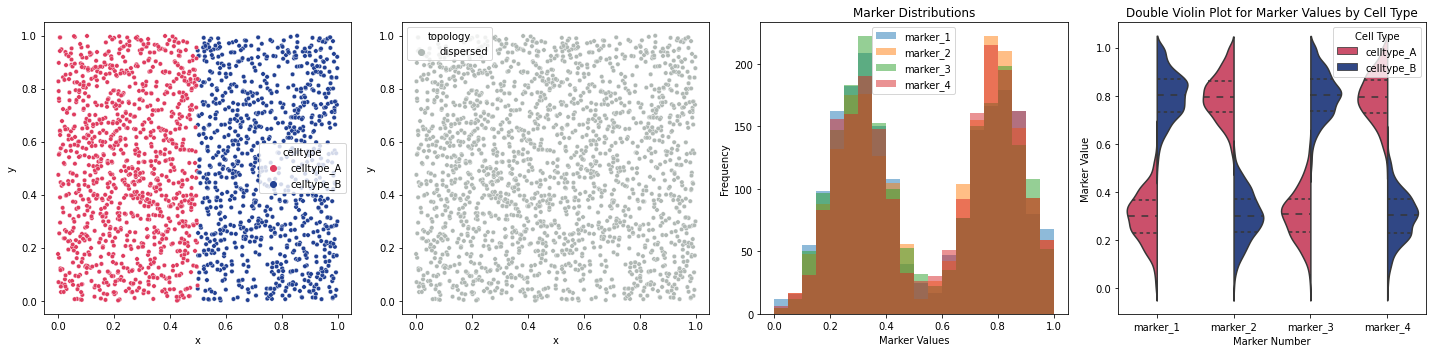

In [4]:
plt.figure(figsize=(20, 5))
# Plot color-coded by cell type
plt.subplot(1,4,1)
sns.scatterplot(x=synthetic_dataset['x'], y=synthetic_dataset['y'], hue=synthetic_dataset['celltype'], s=20, palette={'celltype_A':'#df3c5f', 'celltype_B':'#224193'})
# Plot color-coded by topology
plt.subplot(1,4,2)
sns.scatterplot(x=synthetic_dataset['x'], y=synthetic_dataset['y'], hue=synthetic_dataset['topology'], s=20, palette={'clustered':'#184A45FF', 'dispersed':'#B0B8B4FF'})
# Plot histograms for marker_1 and marker_2
plt.subplot(1,4,3)
plt.hist(synthetic_dataset['marker_1'], bins=20, alpha=0.5, label='marker_1')
plt.hist(synthetic_dataset['marker_2'], bins=20, alpha=0.5, label='marker_2')
plt.hist(synthetic_dataset['marker_3'], bins=20, alpha=0.5, label='marker_3')
plt.hist(synthetic_dataset['marker_4'], bins=20, alpha=0.5, label='marker_4')
plt.title('Marker Distributions')
plt.xlabel('Marker Values')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
# Plot marker intensities by cell type (double violin plot)
plt.subplot(1,4,4)
melted_data = pd.melt(synthetic_dataset, id_vars=['celltype'], value_vars=['marker_1', 'marker_2', 'marker_3', 'marker_4'])
sns.violinplot(x='variable', y='value', hue='celltype', data=melted_data, split=True, inner='quart', palette={'celltype_A':'#df3c5f', 'celltype_B':'#224193'})
plt.title('Double Violin Plot for Marker Values by Cell Type')
plt.xlabel('Marker Number')
plt.ylabel('Marker Value')
plt.legend(title='Cell Type')
plt.show()

In [5]:
synthetic_dataset["fov"] = "FOV1"
synthetic_dataset["fov"] = synthetic_dataset["fov"].astype("category")
features = ["marker_1", "marker_2", "marker_3", "marker_4"]
obs_features = ["x", "y", "celltype", "topology", "fov"]
adata = anndata.AnnData(X = synthetic_dataset[features].to_numpy(), obs = synthetic_dataset[obs_features])
adata.var_names = synthetic_dataset[features].columns
adata.obsm['spatial'] = adata.obs[["x","y"]].to_numpy()
sq.gr.spatial_neighbors(adata,radius=10,coord_type='generic',delaunay=True,library_key="fov")
adata

AnnData object with n_obs × n_vars = 2000 × 4
    obs: 'x', 'y', 'celltype', 'topology', 'fov'
    uns: 'spatial_neighbors'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [6]:
gae = gf.ml.GAE(adata,layers=[10],lr=0.1,distance_threshold=0.08)
gae.train(200, update_interval=50)
gae.load_embedding(adata,encoding_key="X_grafiti")

Generating PyTorch Geometric Dataset...
Setting up Model...
Ready to train!
Epoch 0 ** iteration 0 ** Loss: 700.2257080078125
Epoch 50 ** iteration 50 ** Loss: 460.6598803710938
Epoch 100 ** iteration 100 ** Loss: 187.53113952636718
Epoch 150 ** iteration 150 ** Loss: 75.18179916381835
Complete.


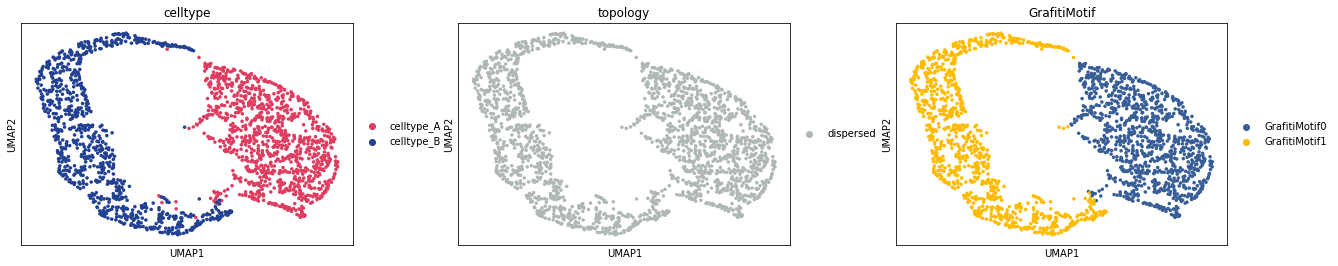

In [7]:
colors={'celltype_A':'#df3c5f','celltype_B':'#224193','clustered':'#184A45FF','dispersed':'#B0B8B4FF',
       'GrafitiMotif0':'#375e97','GrafitiMotif1':'#ffbb00'}
sc.pp.neighbors(adata,use_rep="X_grafiti")
sc.tl.umap(adata)
gf.tl.find_motifs(adata,resolution=0.02,method="leiden",cluster_key="GrafitiMotif")
sc.pl.umap(adata,color=["celltype","topology","GrafitiMotif"],s=50,add_outline=False,wspace=0.2,
           legend_loc='right margin',palette=colors)

<Axes: xlabel='x', ylabel='y'>

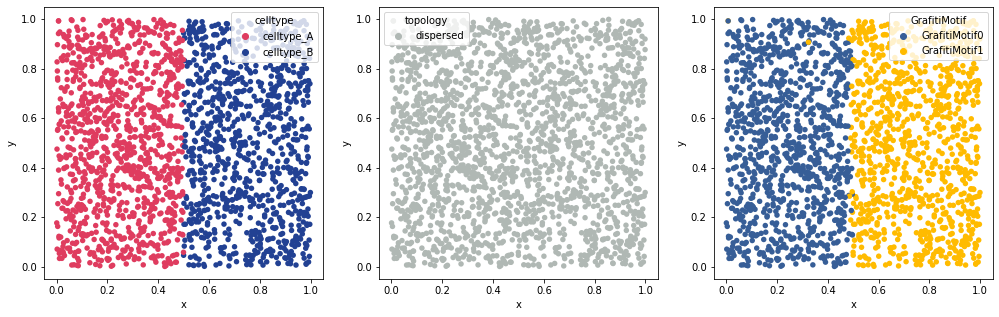

In [8]:
# gf.pl.plot_fraction(adata,"GrafitiMotif","celltype")
# gf.pl.plot_fraction(adata,"GrafitiMotif","topology")
plt.figure(figsize=(17, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x=synthetic_dataset['x'], y=synthetic_dataset['y'], hue=synthetic_dataset['celltype'], s=30, linewidth=0.001, palette={'celltype_A':'#df3c5f','celltype_B':'#224193'})
plt.subplot(1, 3, 2)
sns.scatterplot(x=synthetic_dataset['x'], y=synthetic_dataset['y'], hue=synthetic_dataset['topology'], s=30, linewidth=0.001, palette={'clustered':'#184A45FF','dispersed':'#B0B8B4FF'})
plt.subplot(1, 3, 3)
sns.scatterplot(x=adata.obs['x'], y=adata.obs['y'], hue=adata.obs['GrafitiMotif'], s=30, linewidth=0.001, palette={'GrafitiMotif0':'#375e97','GrafitiMotif1':'#ffbb00'})
# plt.savefig("scenario1_fovplot.pdf",transparent=None,dpi='figure',format=None,metadata=None,bbox_inches=None,
#             pad_inches=0.1,facecolor='auto',edgecolor='auto',backend=None)

## SCENARIO 2: cell type related motifs
### Same topology (clustered), different features

In [9]:
def generate_synthetic_dataset(num_cells=2000,
                            cluster_probability=1,
                            cluster_size=200,
                            cluster_radius=0.005,
                            marker_means=(0.3, 0.8, 0.3, 0.8, 0.3, 0.8, 0.3, 0.8),
                            marker_SDs=(0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1),
                            dispersed_distance=0.08,
                            num_markers=4):
    random.seed(2)
    np.random.seed(2)
    # Unpack marker_means and marker_SDs into individual variables
    marker_means = np.array(marker_means).reshape(num_markers, -1)
    marker_SDs = np.array(marker_SDs).reshape(num_markers, -1)
    # Generate unique x and y coordinates for all cells in the range [0, 1)
    x = np.random.rand(num_cells)
    y = np.random.rand(num_cells)
    # Generate cell types (celltype_A or celltype_B)
    cell_types = np.random.choice(['celltype_A', 'celltype_B'], size=num_cells) 
    # Generate topology (clustered or dispersed) based on x and y coordinates
    topology = np.where(np.random.rand(num_cells) < cluster_probability, 'clustered', 'dispersed')  
    # Adjust x and y coordinates for clustered cells
    clustered_indices = np.where(topology == 'clustered')[0]
    for i in range(0, len(clustered_indices), cluster_size):
        cluster_x = np.random.normal(loc=x[clustered_indices[i]], scale=cluster_radius,
                                      size=min(cluster_size, len(clustered_indices) - i))
        cluster_y = np.random.normal(loc=y[clustered_indices[i]], scale=cluster_radius,
                                      size=min(cluster_size, len(clustered_indices) - i))
        # Clip the generated coordinates to ensure they are within [0, 1)
        cluster_x = np.clip(cluster_x, 0, 1)
        cluster_y = np.clip(cluster_y, 0, 1)
        # Update only the valid indices with the new coordinates
        x[clustered_indices[i:i + cluster_size]] = cluster_x
        y[clustered_indices[i:i + cluster_size]] = cluster_y
        # Set the cell type for each cell in the cluster to be the same
        cluster_cell_type = np.random.choice(['celltype_A', 'celltype_B'])
        cell_types[clustered_indices[i:i + cluster_size]] = cluster_cell_type
    # Adjust x and y coordinates for dispersed cells based on clustered cells
    dispersed_indices = np.where(topology == 'dispersed')[0]
    for i in dispersed_indices:
        # Check if the dispersed cell is within a specified distance of any clustered cell
        while any(
                np.sqrt((x[i] - x[clustered_indices]) ** 2 + (y[i] - y[clustered_indices]) ** 2) < dispersed_distance):
            # If the dispersed cell is too close to a cluster, generate new coordinates
            x[i] = np.random.uniform(low=0, high=1)
            y[i] = np.random.uniform(low=0, high=1)
    # Generate bimodal marker values for each marker in the range [0, 1)
    markers = []
    for i in range(num_markers):
        # Determine the upregulated and downregulated cell types
        upregulated_celltype = 'celltype_A' if i % 2 == 0 else 'celltype_B'
        downregulated_celltype = 'celltype_B' if i % 2 == 0 else 'celltype_A'
        # Generate values for the upregulated cell type
        upregulated_values = np.clip(np.random.normal(loc=marker_means[i, 1], scale=marker_SDs[i, 1], size=num_cells), 0, 1)
        # Generate values for the downregulated cell type
        downregulated_values = np.clip(np.random.normal(loc=marker_means[i, 0], scale=marker_SDs[i, 0], size=num_cells), 0, 1)
        # Combine values based on the cell type
        marker = np.where(cell_types == upregulated_celltype, upregulated_values, downregulated_values)
        markers.append(marker)
    df = pd.DataFrame({'x': x, 'y': y, 'celltype':cell_types, 'topology': topology})
    # Add marker values to the DataFrame
    for i, marker_values in enumerate(markers):
        df[f'marker_{i+1}'] = marker_values
    return df

In [10]:
synthetic_dataset = generate_synthetic_dataset(num_cells=2000,
                                               cluster_probability=1,
                                               cluster_size=200,
                                               cluster_radius=0.005,
                                               marker_means=(0.3, 0.8, 0.3, 0.8, 0.3, 0.8, 0.3, 0.8),
                                               marker_SDs=(0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1),
                                               dispersed_distance=0.08,
                                               num_markers=4)

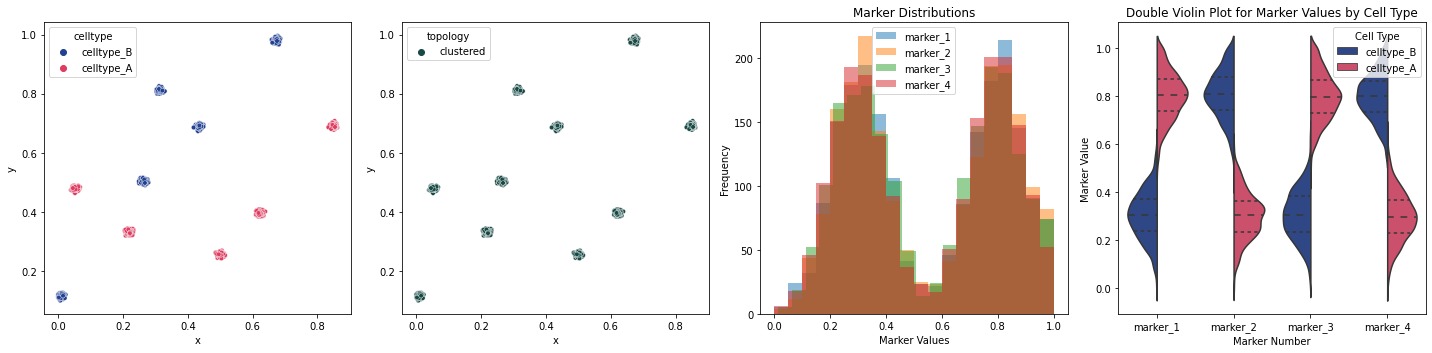

In [11]:
plt.figure(figsize=(20,5))
# Plot color-coded by cell type
plt.subplot(1,4,1)
sns.scatterplot(x=synthetic_dataset['x'], y=synthetic_dataset['y'], hue=synthetic_dataset['celltype'], s=20, palette={'celltype_A':'#df3c5f', 'celltype_B':'#224193'})
# Plot color-coded by topology
plt.subplot(1,4,2)
sns.scatterplot(x=synthetic_dataset['x'], y=synthetic_dataset['y'], hue=synthetic_dataset['topology'], s=20, palette={'clustered':'#184A45FF', 'dispersed':'#B0B8B4FF'})
# Plot histograms for marker_1 and marker_2
plt.subplot(1,4,3)
plt.hist(synthetic_dataset['marker_1'], bins=20, alpha=0.5, label='marker_1')
plt.hist(synthetic_dataset['marker_2'], bins=20, alpha=0.5, label='marker_2')
plt.hist(synthetic_dataset['marker_3'], bins=20, alpha=0.5, label='marker_3')
plt.hist(synthetic_dataset['marker_4'], bins=20, alpha=0.5, label='marker_4')
plt.title('Marker Distributions')
plt.xlabel('Marker Values')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
# Plot marker intensities by cell type (double violin plot)
melted_data = pd.melt(synthetic_dataset, id_vars=['celltype'], value_vars=['marker_1', 'marker_2', 'marker_3', 'marker_4'])
plt.subplot(1,4,4)
sns.violinplot(x='variable', y='value', hue='celltype', data=melted_data, split=True, inner='quart', palette={'celltype_A':'#df3c5f', 'celltype_B':'#224193'})
plt.title('Double Violin Plot for Marker Values by Cell Type')
plt.xlabel('Marker Number')
plt.ylabel('Marker Value')
plt.legend(title='Cell Type')
plt.show()

In [12]:
synthetic_dataset["fov"] = "FOV1"
synthetic_dataset["fov"] = synthetic_dataset["fov"].astype("category")
features = ["marker_1", "marker_2", "marker_3", "marker_4"]
obs_features = ["x", "y", "celltype", "topology", "fov"]
adata = anndata.AnnData(X = synthetic_dataset[features].to_numpy(), obs = synthetic_dataset[obs_features])
adata.var_names = synthetic_dataset[features].columns
adata.obsm['spatial'] = adata.obs[["x","y"]].to_numpy()
sq.gr.spatial_neighbors(adata,radius=10,coord_type='generic',delaunay=True,library_key="fov")
adata

AnnData object with n_obs × n_vars = 2000 × 4
    obs: 'x', 'y', 'celltype', 'topology', 'fov'
    uns: 'spatial_neighbors'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [13]:
gae = gf.ml.GAE(adata,layers=[10],lr=0.1,distance_threshold=0.08)
gae.train(200, update_interval=50)
gae.load_embedding(adata,encoding_key="X_grafiti")

Generating PyTorch Geometric Dataset...
Setting up Model...
Ready to train!
Epoch 0 ** iteration 0 ** Loss: 1014487.6875
Epoch 50 ** iteration 50 ** Loss: 612120.9716210938
Epoch 100 ** iteration 100 ** Loss: 1062.61185546875
Epoch 150 ** iteration 150 ** Loss: 827.1695104980469
Complete.


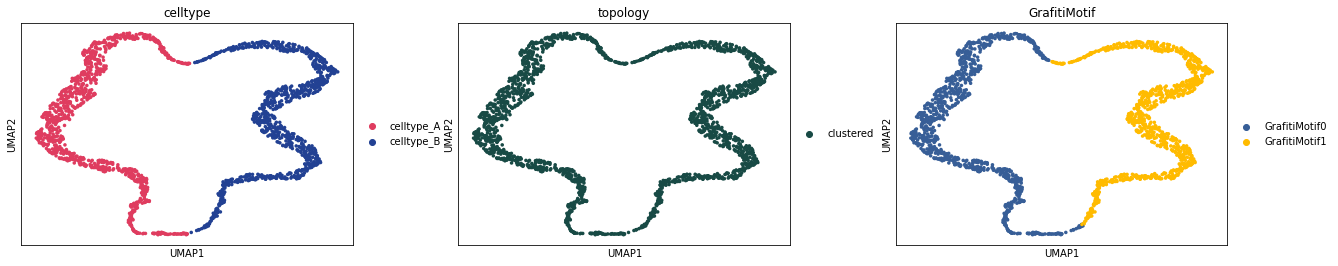

In [16]:
colors={'celltype_A':'#df3c5f','celltype_B':'#224193','clustered':'#184A45FF','dispersed':'#B0B8B4FF',
       'GrafitiMotif0':'#375e97','GrafitiMotif1':'#ffbb00'}
sc.pp.neighbors(adata,use_rep="X_grafiti")
sc.tl.umap(adata)
gf.tl.find_motifs(adata,resolution=0.03,method="leiden",cluster_key="GrafitiMotif")
sc.pl.umap(adata,color=["celltype","topology","GrafitiMotif"],s=50,add_outline=False,wspace=0.2,
           legend_loc='right margin',palette=colors)

<Axes: xlabel='x', ylabel='y'>

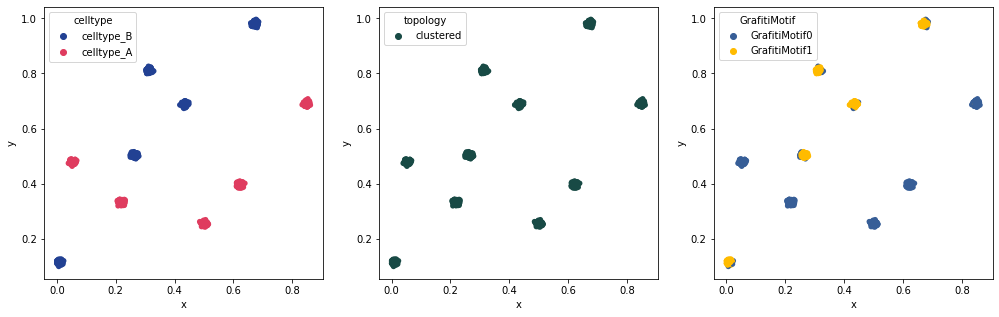

In [17]:
# gf.pl.plot_fraction(adata,"GrafitiMotif","celltype")
# gf.pl.plot_fraction(adata,"GrafitiMotif","topology")
plt.figure(figsize=(17, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x=synthetic_dataset['x'], y=synthetic_dataset['y'], hue=synthetic_dataset['celltype'], s=30, linewidth=0.001, palette={'celltype_A':'#df3c5f','celltype_B':'#224193'})
plt.subplot(1, 3, 2)
sns.scatterplot(x=synthetic_dataset['x'], y=synthetic_dataset['y'], hue=synthetic_dataset['topology'], s=30, linewidth=0.001, palette={'clustered':'#184A45FF','dispersed':'#B0B8B4FF'})
plt.subplot(1, 3, 3)
sns.scatterplot(x=adata.obs['x'], y=adata.obs['y'], hue=adata.obs['GrafitiMotif'], s=30, linewidth=0.001, palette={'GrafitiMotif0':'#375e97','GrafitiMotif1':'#ffbb00'})
# plt.savefig("scenario2_fovplot.pdf",transparent=None,dpi='figure',format=None,metadata=None,bbox_inches=None,
#             pad_inches=0.1,facecolor='auto',edgecolor='auto',backend=None)

## SCENARIO 3: topology related motifs
### Different topologies, different features (random spatial intermixing)

In [18]:
def generate_synthetic_dataset(num_cells=2000,
                        cluster_probability=0.5,
                        cluster_size=100,
                        cluster_radius=0.01,
                        marker_means=(0.3, 0.8, 0.3, 0.8, 0.3, 0.8, 0.3, 0.8),
                        marker_SDs=(0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1),
                        dispersed_distance=0.05,
                        num_markers=4):
    random.seed(2)
    np.random.seed(2)
    # Unpack marker_means and marker_SDs into individual variables
    marker_means = np.array(marker_means).reshape(num_markers, -1)
    marker_SDs = np.array(marker_SDs).reshape(num_markers, -1)
    # Generate unique x and y coordinates for all cells in the range [0, 1)
    x = np.random.rand(num_cells)
    y = np.random.rand(num_cells)
    # Generate cell types (celltype_A or celltype_B)
    cell_types = np.random.choice(['celltype_A', 'celltype_B'], size=num_cells)
    # Generate bimodal marker values for each marker in the range [0, 1)
    markers = []
    for i in range(num_markers):
        # Determine the upregulated and downregulated cell types
        upregulated_celltype = 'celltype_A' if i % 2 == 0 else 'celltype_B'
        downregulated_celltype = 'celltype_B' if i % 2 == 0 else 'celltype_A'      
        # Generate values for the upregulated cell type
        upregulated_values = np.clip(np.random.normal(loc=marker_means[i, 1], scale=marker_SDs[i, 1], size=num_cells), 0, 1)    
        # Generate values for the downregulated cell type
        downregulated_values = np.clip(np.random.normal(loc=marker_means[i, 0], scale=marker_SDs[i, 0], size=num_cells), 0, 1)  
        # Combine values based on the cell type
        marker = np.where(cell_types == upregulated_celltype, upregulated_values, downregulated_values) 
        markers.append(marker)
    # Generate topology (clustered or dispersed) based on x and y coordinates
    topology = np.where(np.random.rand(num_cells) < cluster_probability, 'clustered', 'dispersed')
    # Adjust x and y coordinates for clustered cells
    clustered_indices = np.where(topology == 'clustered')[0]
    for i in range(0, len(clustered_indices), cluster_size):
        cluster_x = np.random.normal(loc=x[clustered_indices[i]], scale=cluster_radius,
                                      size=min(cluster_size, len(clustered_indices) - i))
        cluster_y = np.random.normal(loc=y[clustered_indices[i]], scale=cluster_radius,
                                      size=min(cluster_size, len(clustered_indices) - i))
        # Clip the generated coordinates to ensure they are within [0, 1)
        cluster_x = np.clip(cluster_x, 0, 1)
        cluster_y = np.clip(cluster_y, 0, 1)
        # Filter out indices where the generated coordinates are too close to existing clustered cells
        valid_indices = np.where(
            (np.abs(cluster_x - x[clustered_indices[i:i + cluster_size]]) > cluster_radius) |
            (np.abs(cluster_y - y[clustered_indices[i:i + cluster_size]]) > cluster_radius))[0]
        # Update only the valid indices with the new coordinates
        x[clustered_indices[i:i + cluster_size][valid_indices]] = cluster_x[valid_indices]
        y[clustered_indices[i:i + cluster_size][valid_indices]] = cluster_y[valid_indices]
    # Adjust x and y coordinates for dispersed cells based on clustered cells
    dispersed_indices = np.where(topology == 'dispersed')[0]
    for i in dispersed_indices:
        # Check if the dispersed cell is within a specified distance of any clustered cell
        while any(
                np.sqrt((x[i] - x[clustered_indices]) ** 2 + (y[i] - y[clustered_indices]) ** 2) < dispersed_distance):
            # If the dispersed cell is too close to a cluster, generate new coordinates
            x[i] = np.random.uniform(low=0, high=1)
            y[i] = np.random.uniform(low=0, high=1)
    # Create a DataFrame to store the synthetic dataset
    data_dict = {'x': x, 'y': y, 'celltype': cell_types, 'topology': topology}
    for i in range(num_markers):
        data_dict[f'marker_{i+1}'] = markers[i]
    synthetic_data = pd.DataFrame(data_dict)
    return synthetic_data

In [19]:
synthetic_dataset = generate_synthetic_dataset(num_cells=2000,
                                               cluster_probability=0.5,
                                               cluster_radius=0.01,
                                               cluster_size=200,
                                               marker_means=(0.3, 0.8, 0.3, 0.8, 0.3, 0.8, 0.3, 0.8),
                                               marker_SDs=(0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1),
                                               dispersed_distance=0.05,
                                               num_markers=4)

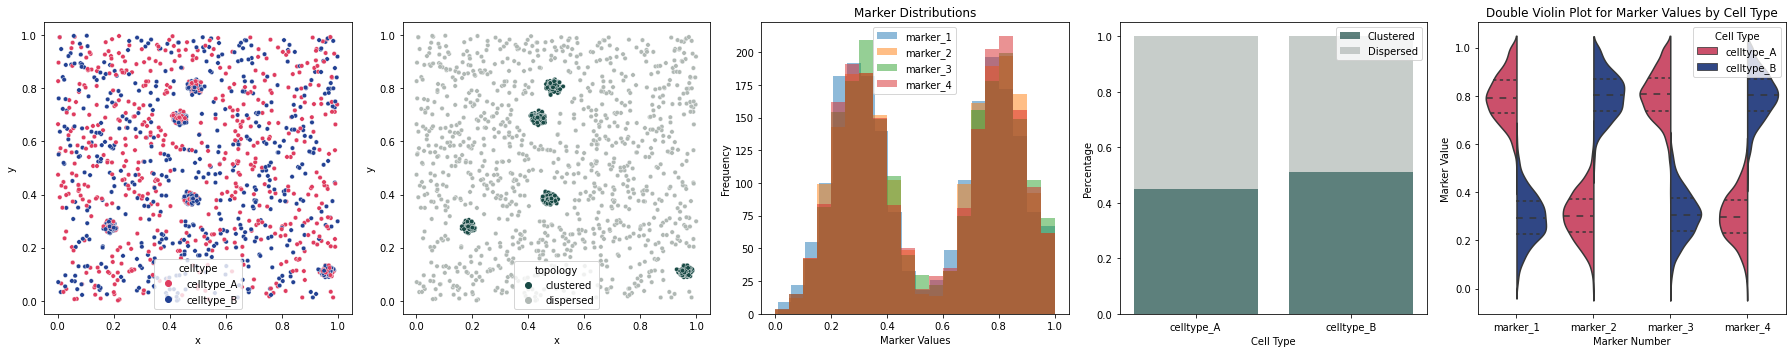

In [20]:
plt.figure(figsize=(25,5))
# Plot color-coded by cell type
plt.subplot(1,5,1)
sns.scatterplot(x=synthetic_dataset['x'], y=synthetic_dataset['y'], hue=synthetic_dataset['celltype'], s=20, palette={'celltype_A':'#df3c5f', 'celltype_B':'#224193'})
# Plot color-coded by topology
plt.subplot(1,5,2)
sns.scatterplot(x=synthetic_dataset['x'], y=synthetic_dataset['y'], hue=synthetic_dataset['topology'], s=20, palette={'clustered':'#184A45FF', 'dispersed':'#B0B8B4FF'})
# Plot histograms for marker_1 and marker_2
plt.subplot(1,5,3)
plt.hist(synthetic_dataset['marker_1'], bins=20, alpha=0.5, label='marker_1')
plt.hist(synthetic_dataset['marker_2'], bins=20, alpha=0.5, label='marker_2')
plt.hist(synthetic_dataset['marker_3'], bins=20, alpha=0.5, label='marker_3')
plt.hist(synthetic_dataset['marker_4'], bins=20, alpha=0.5, label='marker_4')
plt.title('Marker Distributions')
plt.xlabel('Marker Values')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
# Plot percentage of cells in each cell type that are clustered or dispersed
plt.subplot(1,5,4)
clustered_percentages = synthetic_dataset.groupby('celltype')['topology'].value_counts(normalize=True)[:, 'clustered']
dispersed_percentages = synthetic_dataset.groupby('celltype')['topology'].value_counts(normalize=True)[:, 'dispersed']
bar_positions = np.arange(len(clustered_percentages))
plt.bar(bar_positions, clustered_percentages, label='Clustered', color='#184A45FF', alpha=0.7)
plt.bar(bar_positions, dispersed_percentages, bottom=clustered_percentages, label='Dispersed', color='#B0B8B4FF', alpha=0.7)
plt.xlabel('Cell Type')
plt.ylabel('Percentage')
plt.xticks(bar_positions, clustered_percentages.index)
plt.legend()
# Plot marker intensities by cell type (double violin plot)
melted_data = pd.melt(synthetic_dataset, id_vars=['celltype'], value_vars=['marker_1', 'marker_2', 'marker_3', 'marker_4'])
plt.subplot(1,5,5)
sns.violinplot(x='variable', y='value', hue='celltype', data=melted_data, split=True, inner='quart', palette={'celltype_A':'#df3c5f', 'celltype_B':'#224193'})
plt.title('Double Violin Plot for Marker Values by Cell Type')
plt.xlabel('Marker Number')
plt.ylabel('Marker Value')
plt.legend(title='Cell Type')

In [21]:
synthetic_dataset["fov"] = "FOV1"
synthetic_dataset["fov"] = synthetic_dataset["fov"].astype("category")
features = ["marker_1", "marker_2", "marker_3", "marker_4"]
obs_features = ["x", "y", "celltype", "topology", "fov"]
adata = anndata.AnnData(X = synthetic_dataset[features].to_numpy(), obs = synthetic_dataset[obs_features])
adata.var_names = synthetic_dataset[features].columns
adata.obsm['spatial'] = adata.obs[["x","y"]].to_numpy()
sq.gr.spatial_neighbors(adata,coord_type='generic',delaunay=True,library_key="fov")
adata

AnnData object with n_obs × n_vars = 2000 × 4
    obs: 'x', 'y', 'celltype', 'topology', 'fov'
    uns: 'spatial_neighbors'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [22]:
gae = gf.ml.GAE(adata,layers=[10],lr=0.1,distance_threshold=0.08)
gae.train(200, update_interval=50)
gae.load_embedding(adata,encoding_key="X_grafiti")

Generating PyTorch Geometric Dataset...
Setting up Model...
Ready to train!
Epoch 0 ** iteration 0 ** Loss: 40009.8046875
Epoch 50 ** iteration 50 ** Loss: 26802.079560546874
Epoch 100 ** iteration 100 ** Loss: 1163.8608923339843
Epoch 150 ** iteration 150 ** Loss: 35.680514087677004
Complete.


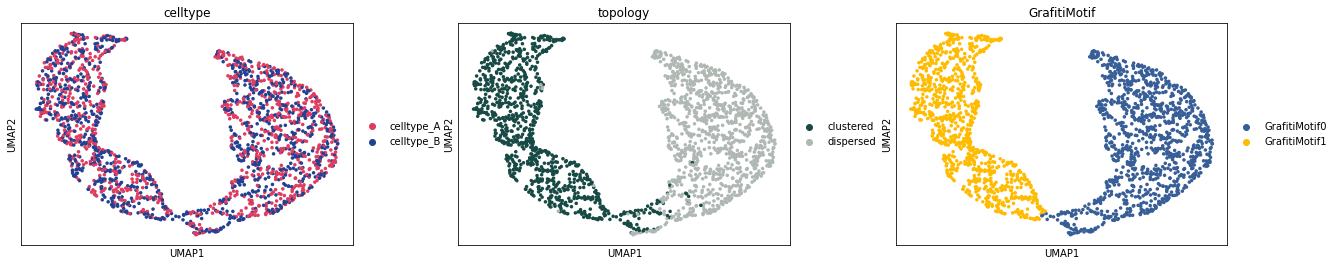

In [23]:
colors={'celltype_A':'#df3c5f','celltype_B':'#224193','clustered':'#184A45FF','dispersed':'#B0B8B4FF',
       'GrafitiMotif0':'#375e97','GrafitiMotif1':'#ffbb00'}
sc.pp.neighbors(adata,use_rep="X_grafiti")
sc.tl.umap(adata)
gf.tl.find_motifs(adata,resolution=0.03,method="leiden",cluster_key="GrafitiMotif")
sc.pl.umap(adata,color=["celltype","topology","GrafitiMotif"],s=50,add_outline=False,wspace=0.2,
           legend_loc='right margin',palette=colors)

<Axes: xlabel='x', ylabel='y'>

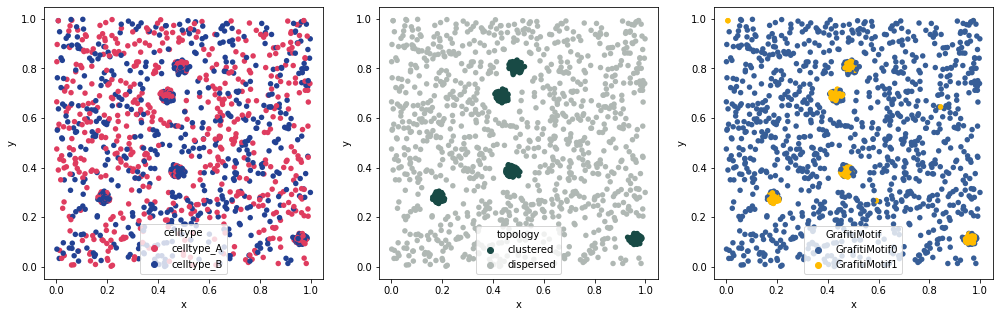

In [24]:
# gf.pl.plot_fraction(adata,"GrafitiMotif","celltype")
# gf.pl.plot_fraction(adata,"GrafitiMotif","topology")
plt.figure(figsize=(17, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x=synthetic_dataset['x'], y=synthetic_dataset['y'], hue=synthetic_dataset['celltype'], s=30, linewidth=0.001, palette={'celltype_A':'#df3c5f','celltype_B':'#224193'})
plt.subplot(1, 3, 2)
sns.scatterplot(x=synthetic_dataset['x'], y=synthetic_dataset['y'], hue=synthetic_dataset['topology'], s=30, linewidth=0.001, palette={'clustered':'#184A45FF','dispersed':'#B0B8B4FF'})
plt.subplot(1, 3, 3)
sns.scatterplot(x=adata.obs['x'], y=adata.obs['y'], hue=adata.obs['GrafitiMotif'], s=30, linewidth=0.001, palette={'GrafitiMotif0':'#375e97','GrafitiMotif1':'#ffbb00'})
# plt.savefig("scenario3_fovplot.pdf",transparent=None,dpi='figure',format=None,metadata=None,bbox_inches=None,
#             pad_inches=0.1,facecolor='auto',edgecolor='auto',backend=None)

## SCENARIO 4: cell type and topology related motifs
### Different topologies, different features (clear spatially defined pattern)

In [25]:
def generate_synthetic_dataset(num_cells=2000,
                        cluster_probability=0.5,
                        cluster_size=100,
                        cluster_radius=0.01,
                        marker_means_A=(0.3, 0.8), 
                        marker_means_B=(0.8, 0.3),
                        marker_SDs_A=(0.1, 0.1), 
                        marker_SDs_B=(0.1, 0.1),
                        dispersed_distance=0.05,
                        num_markers=4):
    random.seed(4)
    np.random.seed(4)
    # Generate unique x and y coordinates for all cells in the range [0, 1)
    x = np.random.rand(num_cells)
    y = np.random.rand(num_cells)
    # Generate topology (clustered or dispersed) based on x and y coordinates
    topology = np.where(np.random.rand(num_cells) < cluster_probability, 'clustered', 'dispersed')
    # Adjust x and y coordinates for clustered cells
    clustered_indices = np.where(topology == 'clustered')[0]
    for i in range(0, len(clustered_indices), cluster_size):
        cluster_x = np.random.normal(loc=x[clustered_indices[i]], scale=cluster_radius,
                                      size=min(cluster_size, len(clustered_indices) - i))
        cluster_y = np.random.normal(loc=y[clustered_indices[i]], scale=cluster_radius,
                                      size=min(cluster_size, len(clustered_indices) - i))
        # Clip the generated coordinates to ensure they are within [0, 1)
        cluster_x = np.clip(cluster_x, 0, 1)
        cluster_y = np.clip(cluster_y, 0, 1)
        # Filter out indices where the generated coordinates are too close to existing clustered cells
        valid_indices = np.where(
            (np.abs(cluster_x - x[clustered_indices[i:i + cluster_size]]) > cluster_radius) |
            (np.abs(cluster_y - y[clustered_indices[i:i + cluster_size]]) > cluster_radius))[0]
        # Update only the valid indices with the new coordinates
        x[clustered_indices[i:i + cluster_size][valid_indices]] = cluster_x[valid_indices]
        y[clustered_indices[i:i + cluster_size][valid_indices]] = cluster_y[valid_indices]
    # Adjust x and y coordinates for dispersed cells based on clustered cells
    dispersed_indices = np.where(topology == 'dispersed')[0]
    for i in dispersed_indices:
        # Check if the dispersed cell is within a specified distance of any clustered cell
        while any(
                np.sqrt((x[i] - x[clustered_indices]) ** 2 + (y[i] - y[clustered_indices]) ** 2) < dispersed_distance):
            # If the dispersed cell is too close to a cluster, generate new coordinates
            x[i] = np.random.uniform(low=0, high=1)
            y[i] = np.random.uniform(low=0, high=1)
    # Assign cell types based on coordinates
    celltype_A_mask = (x < 0.5) & (y >= 0) & (y <= 1)
    celltype_B_mask = (x >= 0.5) & (y >= 0) & (y <= 1)
    # Generate marker values using bimodal distribution for each marker
    markers = []
    for i in range(num_markers):
        # Determine the upregulated and downregulated cell types
        upregulated_celltype = 'celltype_B' if i % 2 == 0 else 'celltype_A'
        downregulated_celltype = 'celltype_A' if i % 2 == 0 else 'celltype_B' 
        # Generate values for the upregulated cell type
        upregulated_values = np.clip(np.random.normal(loc=marker_means_A[i % 2], scale=marker_SDs_A[i % 2], size=num_cells), 0, 1) 
        # Generate values for the downregulated cell type
        downregulated_values = np.clip(np.random.normal(loc=marker_means_B[i % 2], scale=marker_SDs_B[i % 2], size=num_cells), 0, 1)
        # Combine values based on the cell type
        marker_values = np.where(celltype_A_mask, upregulated_values, downregulated_values)
        markers.append(marker_values)
    # Create a DataFrame to store the synthetic dataset
    data_dict = {'x': x, 
                 'y': y, 
                 'celltype': np.where(celltype_A_mask, 'celltype_A', 'celltype_B'), 
                 'topology': topology}
    for i in range(num_markers):
        data_dict[f'marker_{i+1}'] = markers[i]
    synthetic_data = pd.DataFrame(data_dict)
    return synthetic_data

In [26]:
synthetic_dataset = generate_synthetic_dataset(num_cells=2000,
                                               cluster_probability=0.5,
                                               cluster_size=100,
                                               cluster_radius=0.01,
                                               marker_means_A=(0.3, 0.8),
                                               marker_means_B=(0.8, 0.3),
                                               marker_SDs_A=(0.1, 0.1),
                                               marker_SDs_B=(0.1, 0.1),
                                               dispersed_distance=0.05,
                                               num_markers=4)

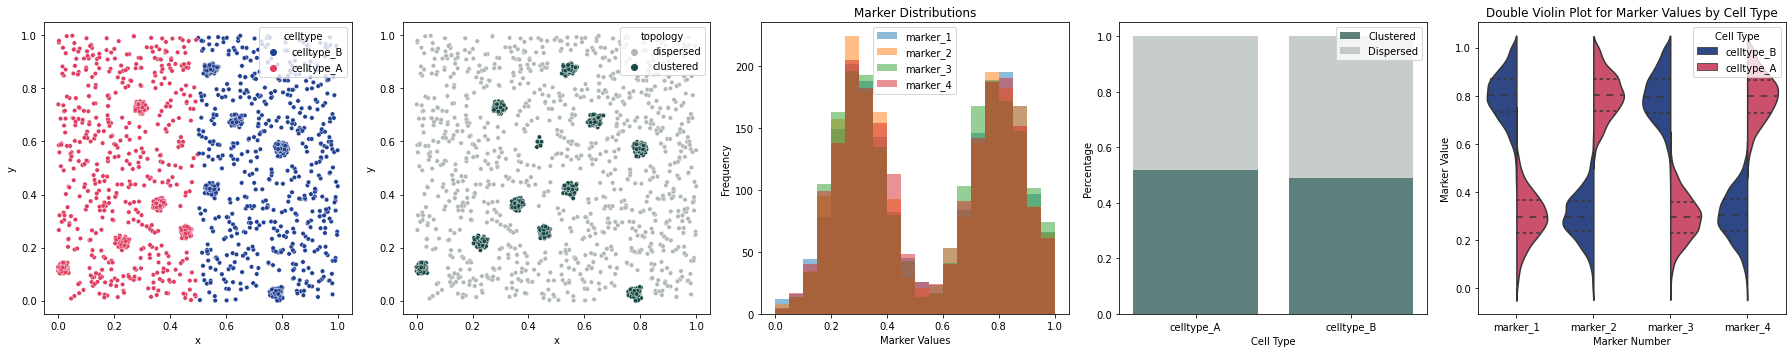

In [27]:
plt.figure(figsize=(25,5))
# Plot color-coded by cell type
plt.subplot(1,5,1)
sns.scatterplot(x=synthetic_dataset['x'], y=synthetic_dataset['y'], hue=synthetic_dataset['celltype'], s=20, palette={'celltype_A':'#df3c5f', 'celltype_B':'#224193'})
# Plot color-coded by topology
plt.subplot(1,5,2)
sns.scatterplot(x=synthetic_dataset['x'], y=synthetic_dataset['y'], hue=synthetic_dataset['topology'], s=20, palette={'clustered':'#184A45FF', 'dispersed':'#B0B8B4FF'})
# Plot histograms for marker_1 and marker_2
plt.subplot(1,5,3)
plt.hist(synthetic_dataset['marker_1'], bins=20, alpha=0.5, label='marker_1')
plt.hist(synthetic_dataset['marker_2'], bins=20, alpha=0.5, label='marker_2')
plt.hist(synthetic_dataset['marker_3'], bins=20, alpha=0.5, label='marker_3')
plt.hist(synthetic_dataset['marker_4'], bins=20, alpha=0.5, label='marker_4')
plt.title('Marker Distributions')
plt.xlabel('Marker Values')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
# Plot percentage of cells in each cell type that are clustered or dispersed
plt.subplot(1,5,4)
clustered_percentages = synthetic_dataset.groupby('celltype')['topology'].value_counts(normalize=True)[:, 'clustered']
dispersed_percentages = synthetic_dataset.groupby('celltype')['topology'].value_counts(normalize=True)[:, 'dispersed']
bar_positions = np.arange(len(clustered_percentages))
plt.bar(bar_positions, clustered_percentages, label='Clustered', color='#184A45FF', alpha=0.7)
plt.bar(bar_positions, dispersed_percentages, bottom=clustered_percentages, label='Dispersed', color='#B0B8B4FF', alpha=0.7)
plt.xlabel('Cell Type')
plt.ylabel('Percentage')
plt.xticks(bar_positions, clustered_percentages.index)
plt.legend()
# Plot marker intensities by cell type (double violin plot)
melted_data = pd.melt(synthetic_dataset, id_vars=['celltype'], value_vars=['marker_1', 'marker_2', 'marker_3', 'marker_4'])
plt.subplot(1,5,5)
sns.violinplot(x='variable', y='value', hue='celltype', data=melted_data, split=True, inner='quart', palette={'celltype_A':'#df3c5f', 'celltype_B':'#224193'})
plt.title('Double Violin Plot for Marker Values by Cell Type')
plt.xlabel('Marker Number')
plt.ylabel('Marker Value')
plt.legend(title='Cell Type')
plt.show()

In [28]:
synthetic_dataset["fov"] = "FOV1"
synthetic_dataset["fov"] = synthetic_dataset["fov"].astype("category")
features = ["marker_1", "marker_2", "marker_3", "marker_4"]
obs_features = ["x", "y", "celltype", "topology", "fov"]
adata = anndata.AnnData(X = synthetic_dataset[features].to_numpy(), obs = synthetic_dataset[obs_features])
adata.var_names = synthetic_dataset[features].columns
adata.obsm['spatial'] = adata.obs[["x","y"]].to_numpy()
sq.gr.spatial_neighbors(adata,radius=10,coord_type='generic',delaunay=True,library_key="fov")
adata

AnnData object with n_obs × n_vars = 2000 × 4
    obs: 'x', 'y', 'celltype', 'topology', 'fov'
    uns: 'spatial_neighbors'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [31]:
gae = gf.ml.GAE(adata,layers=[10],lr=0.1,distance_threshold=0.08)
gae.train(400, update_interval=50)
gae.load_embedding(adata,encoding_key="X_grafiti")

Generating PyTorch Geometric Dataset...
Setting up Model...
Ready to train!
Epoch 0 ** iteration 0 ** Loss: 12766.4033203125
Epoch 50 ** iteration 50 ** Loss: 9502.731533203125
Epoch 100 ** iteration 100 ** Loss: 5021.482592773437
Epoch 150 ** iteration 150 ** Loss: 2303.700419921875
Epoch 200 ** iteration 200 ** Loss: 798.9164544677734
Epoch 250 ** iteration 250 ** Loss: 191.27667037963866
Epoch 300 ** iteration 300 ** Loss: 40.28779811859131
Epoch 350 ** iteration 350 ** Loss: 13.840372714996338
Complete.


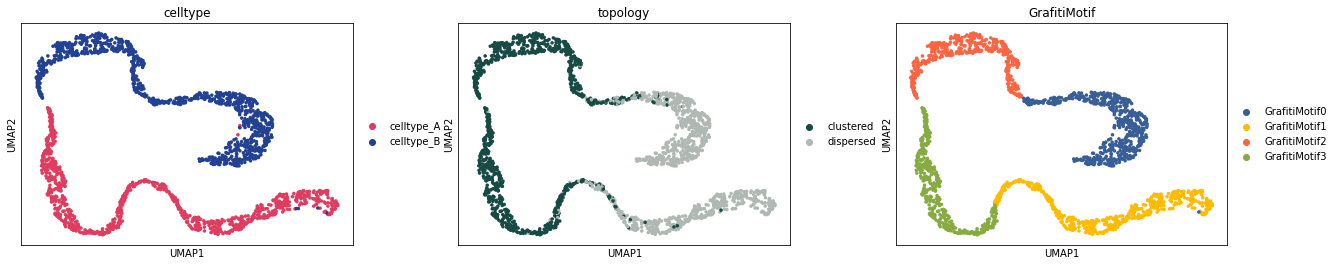

In [32]:
colors={'celltype_A':'#df3c5f','celltype_B':'#224193','clustered':'#184A45FF','dispersed':'#B0B8B4FF',
       'GrafitiMotif0':'#375e97','GrafitiMotif1':'#ffbb00','GrafitiMotif2':'#fb6542','GrafitiMotif3':'#86ac41'}
sc.pp.neighbors(adata,use_rep="X_grafiti")
sc.tl.umap(adata)
gf.tl.find_motifs(adata,resolution=0.05,method="leiden",cluster_key="GrafitiMotif")
sc.pl.umap(adata,color=["celltype","topology","GrafitiMotif"],s=50,add_outline=False,wspace=0.2,
           legend_loc='right margin',palette=colors)

<Axes: xlabel='x', ylabel='y'>

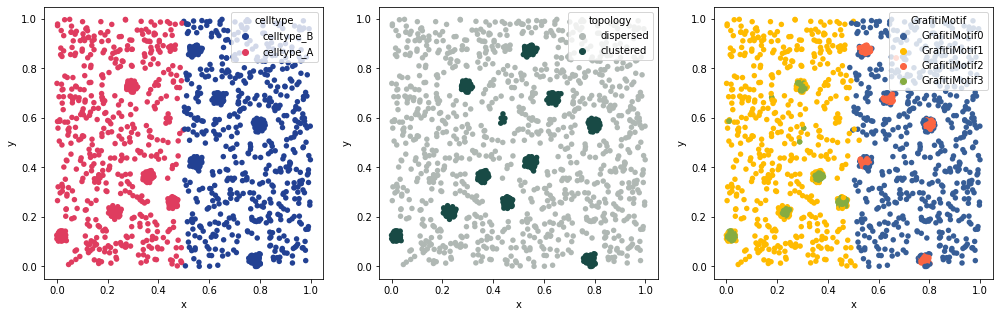

In [33]:
# gf.pl.plot_fraction(adata,"GrafitiMotif","celltype")
# gf.pl.plot_fraction(adata,"GrafitiMotif","topology")
plt.figure(figsize=(17, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x=synthetic_dataset['x'], y=synthetic_dataset['y'], hue=synthetic_dataset['celltype'], s=30, linewidth=0.001, palette={'celltype_A':'#df3c5f','celltype_B':'#224193'})
plt.subplot(1, 3, 2)
sns.scatterplot(x=synthetic_dataset['x'], y=synthetic_dataset['y'], hue=synthetic_dataset['topology'], s=30, linewidth=0.001, palette={'clustered':'#184A45FF','dispersed':'#B0B8B4FF'})
plt.subplot(1, 3, 3)
sns.scatterplot(x=adata.obs['x'], y=adata.obs['y'], hue=adata.obs['GrafitiMotif'], s=30, linewidth=0.001, palette={'GrafitiMotif0':'#375e97','GrafitiMotif1':'#ffbb00','GrafitiMotif2':'#fb6542','GrafitiMotif3':'#86ac41'})
# plt.savefig("scenario4_fovplot.pdf",transparent=None,dpi='figure',format=None,metadata=None,bbox_inches=None,
#             pad_inches=0.1,facecolor='auto',edgecolor='auto',backend=None)

## Iterations

In [2]:
def generate_synthetic_dataset_scenario1(num_cells=2000, 
                               boundary_jitter=0, 
                               num_markers=4,
                               marker_means_A=(0.3, 0.8), 
                               marker_means_B=(0.8, 0.3),
                               marker_SDs_A=(0.1, 0.1),  
                               marker_SDs_B=(0.1, 0.1),
                               seed=4):
    random.seed(seed)
    np.random.seed(seed)
    x_coordinates = np.random.rand(num_cells)
    y_coordinates = np.random.rand(num_cells)
    boundary = 0.5 + np.random.uniform(-boundary_jitter, boundary_jitter, num_cells)
    celltype_A_mask = (x_coordinates <= boundary) & (y_coordinates >= 0) & (y_coordinates <= 1)
    celltype_B_mask = (x_coordinates > boundary) & (y_coordinates >= 0) & (y_coordinates <= 1)
    markers = []
    for i in range(num_markers):
        upregulated_celltype = 'celltype_B' if i % 2 == 0 else 'celltype_A'
        downregulated_celltype = 'celltype_A' if i % 2 == 0 else 'celltype_B'
        upregulated_values = np.clip(np.random.normal(loc=marker_means_A[i % 2], scale=marker_SDs_A[i % 2], size=num_cells), 0, 1)
        downregulated_values = np.clip(np.random.normal(loc=marker_means_B[i % 2], scale=marker_SDs_B[i % 2], size=num_cells), 0, 1)
        marker_values = np.where(celltype_A_mask, upregulated_values, downregulated_values)
        markers.append(marker_values)
    data = {'x':x_coordinates,'y':y_coordinates,'celltype':np.where(celltype_A_mask,'celltype_A','celltype_B'),
            'topology':'dispersed'}
    for i, marker_values in enumerate(markers):
        data[f'marker_{i+1}'] = marker_values
    df = pd.DataFrame(data)
    return df
def generate_synthetic_dataset_scenario4(num_cells=2000,
                                    cluster_probability=0.5,
                                    cluster_size=100,
                                    cluster_radius=0.01,
                                    marker_means_A=(0.3, 0.8), 
                                    marker_means_B=(0.8, 0.3),
                                    marker_SDs_A=(0.1, 0.1), 
                                    marker_SDs_B=(0.1, 0.1),
                                    dispersed_distance=0.05,
                                    num_markers=4,
                                    seed=12):
    random.seed(seed)
    np.random.seed(seed)
    x = np.random.rand(num_cells)
    y = np.random.rand(num_cells)
    topology = np.where(np.random.rand(num_cells) < cluster_probability, 'clustered', 'dispersed')
    clustered_indices = np.where(topology == 'clustered')[0]
    for i in range(0, len(clustered_indices), cluster_size):
        cluster_x = np.random.normal(loc=x[clustered_indices[i]], scale=cluster_radius,
                                      size=min(cluster_size, len(clustered_indices) - i))
        cluster_y = np.random.normal(loc=y[clustered_indices[i]], scale=cluster_radius,
                                      size=min(cluster_size, len(clustered_indices) - i))
        cluster_x = np.clip(cluster_x, 0, 1)
        cluster_y = np.clip(cluster_y, 0, 1)
        valid_indices = np.where(
            (np.abs(cluster_x - x[clustered_indices[i:i + cluster_size]]) > cluster_radius) |
            (np.abs(cluster_y - y[clustered_indices[i:i + cluster_size]]) > cluster_radius))[0]
        x[clustered_indices[i:i + cluster_size][valid_indices]] = cluster_x[valid_indices]
        y[clustered_indices[i:i + cluster_size][valid_indices]] = cluster_y[valid_indices]
    dispersed_indices = np.where(topology == 'dispersed')[0]
    for i in dispersed_indices:
        while any(
                np.sqrt((x[i] - x[clustered_indices]) ** 2 + (y[i] - y[clustered_indices]) ** 2) < dispersed_distance):
            x[i] = np.random.uniform(low=0, high=1)
            y[i] = np.random.uniform(low=0, high=1)
    celltype_A_mask = (x < 0.5) & (y >= 0) & (y <= 1)
    celltype_B_mask = (x >= 0.5) & (y >= 0) & (y <= 1)
    markers = []
    for i in range(num_markers):
        upregulated_celltype = 'celltype_B' if i % 2 == 0 else 'celltype_A'
        downregulated_celltype = 'celltype_A' if i % 2 == 0 else 'celltype_B'
        upregulated_values = np.clip(np.random.normal(loc=marker_means_A[i % 2], scale=marker_SDs_A[i % 2], size=num_cells), 0, 1)
        downregulated_values = np.clip(np.random.normal(loc=marker_means_B[i % 2], scale=marker_SDs_B[i % 2], size=num_cells), 0, 1)
        marker_values = np.where(celltype_A_mask, upregulated_values, downregulated_values)
        markers.append(marker_values)
    data_dict = {'x':x,'y':y,'celltype':np.where(celltype_A_mask,'celltype_A','celltype_B'),'topology':topology}
    for i in range(num_markers):
        data_dict[f'marker_{i+1}'] = markers[i]
    synthetic_data = pd.DataFrame(data_dict)
    return synthetic_data
def plot(synthetic_dataset):
    plt.figure(figsize=(16,4))
    plt.subplot(1,4,1)
    sns.scatterplot(x=synthetic_dataset['x'], y=synthetic_dataset['y'], hue=synthetic_dataset['celltype'], s=20, palette={'celltype_A':'#df3c5f', 'celltype_B':'#224193'})
    plt.subplot(1,4,2)
    sns.scatterplot(x=synthetic_dataset['x'], y=synthetic_dataset['y'], hue=synthetic_dataset['topology'], s=20, palette={'clustered':'#184A45FF', 'dispersed':'#B0B8B4FF'})
    plt.subplot(1,4,3)
    plt.hist(synthetic_dataset['marker_1'], bins=20, alpha=0.5, label='marker_1')
    plt.hist(synthetic_dataset['marker_2'], bins=20, alpha=0.5, label='marker_2')
    plt.hist(synthetic_dataset['marker_3'], bins=20, alpha=0.5, label='marker_3')
    plt.hist(synthetic_dataset['marker_4'], bins=20, alpha=0.5, label='marker_4')
    plt.title('Marker Distributions')
    plt.xlabel('Marker Values')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    melted_data = pd.melt(synthetic_dataset, id_vars=['celltype'], value_vars=['marker_1', 'marker_2', 'marker_3', 'marker_4'])
    plt.subplot(1,4,4)
    sns.violinplot(x='variable', y='value', hue='celltype', data=melted_data, split=True, inner='quart', palette={'celltype_A':'#df3c5f', 'celltype_B':'#224193'})
    plt.title('Double Violin Plot for Marker Values by Cell Type')
    plt.xlabel('Marker Number')
    plt.ylabel('Marker Value')
    plt.legend(title='Cell Type')
    plt.show()
def run_grafiti(synthetic_dataset):
    synthetic_dataset["fov"] = "FOV1"
    synthetic_dataset["fov"] = synthetic_dataset["fov"].astype("category")
    synthetic_dataset["ground_truth_label"] = synthetic_dataset['celltype'] + '_' + synthetic_dataset['topology']
    features = ["marker_1", "marker_2", "marker_3", "marker_4"]
    obs_features = ["x", "y", "celltype", "topology", "fov", "ground_truth_label"]
    adata = anndata.AnnData(X = synthetic_dataset[features].to_numpy(), obs = synthetic_dataset[obs_features])
    adata.var_names = synthetic_dataset[features].columns
    adata.obsm['spatial'] = adata.obs[["x","y"]].to_numpy()
    sq.gr.spatial_neighbors(adata,radius=10,coord_type='generic',delaunay=True,library_key="fov")
    gae = gf.ml.GAE(adata,layers=[10],lr=0.1,distance_threshold=0.08)
    gae.train(300, update_interval=280)
    gae.load_embedding(adata,encoding_key="X_grafiti")
    if len(set(synthetic_dataset["topology"])) > 1:
        dbs_top = davies_bouldin_score(adata.obsm['X_grafiti'], adata.obs["topology"])
    else:
        dbs_top = 0
    if len(set(synthetic_dataset["celltype"])) > 1:
        dbs_ct = davies_bouldin_score(adata.obsm['X_grafiti'], adata.obs["celltype"])
    else:
        dbs_ct = 0
    silhouette_avg = silhouette_score(adata.obsm["X_grafiti"], adata.obs["ground_truth_label"])
    return dbs_top,dbs_ct,silhouette_avg

In [3]:
daviesbouldin_df = pd.DataFrame(columns=['Run','Condition','DBS_topology','DBS_celltype','Silhouette_score'])

In [60]:
a = [0.5,0.5,0.5,0.5]
b = [0.4,0.6,0.6,0.4]
c = [0.3,0.7,0.7,0.3]
d = [0.2,0.8,0.8,0.2]
e = [0.1,0.9,0.9,0.1]
f = [0,1,1,0]
params = [a,b,c,d,e,f]

for run in range(20):
    print(run)
    #CONDITION 1: scenario 1
    params_name = ['0a','0b','0c','0d','0e','0f']
    for i, k in zip(params, params_name):
        val1,val2,val3,val4 = i
        synthetic_dataset = generate_synthetic_dataset_scenario1(num_cells=2000,
                                                                boundary_jitter=0,
                                                                num_markers=4,
                                                                marker_means_A=(val1,val2),
                                                                marker_means_B=(val3,val4),
                                                                marker_SDs_A=(0.1, 0.1),
                                                                marker_SDs_B=(0.1, 0.1),
                                                                seed=run)
        plot(synthetic_dataset)
        dbs_top, dbs_ct, silhouette_avg = run_grafiti(synthetic_dataset)
        df_temp = pd.DataFrame({'Run':[run],'Condition':[k],'DBS_topology':[dbs_top],'DBS_celltype':[dbs_ct],
                                'Silhouette_score':[silhouette_avg]})
        daviesbouldin_df = pd.concat([daviesbouldin_df,df_temp], ignore_index=True)
    #CONDITION 2: scenario 4 cluster radius 0.05
    params_name = ['0.05a','0.05b','0.05c','0.05d','0.05e','0.05f']
    for i, k in zip(params, params_name):
        val1,val2,val3,val4 = i
        synthetic_dataset = generate_synthetic_dataset_scenario4(num_cells=2000,
                                                    cluster_probability=0.5,
                                                    cluster_size=100,
                                                    cluster_radius=0.05,
                                                    marker_means_A=(val1,val2),
                                                    marker_means_B=(val3,val4),
                                                    marker_SDs_A=(0.1, 0.1),
                                                    marker_SDs_B=(0.1, 0.1),
                                                    dispersed_distance=0.05,
                                                    num_markers=4,
                                                    seed=run)
        plot(synthetic_dataset)
        dbs_top, dbs_ct, silhouette_avg = run_grafiti(synthetic_dataset)
        df_temp = pd.DataFrame({'Run':[run],'Condition':[k],'DBS_topology':[dbs_top],'DBS_celltype':[dbs_ct],
                                'Silhouette_score':[silhouette_avg]})
        daviesbouldin_df = pd.concat([daviesbouldin_df,df_temp], ignore_index=True)
    #CONDITION 3: scenario 4 cluster radius 0.025
    params_name = ['0.025a','0.025b','0.025c','0.025d','0.025e','0.025f']
    for i, k in zip(params, params_name):
        val1,val2,val3,val4 = i
        synthetic_dataset = generate_synthetic_dataset_scenario4(num_cells=2000,
                                                    cluster_probability=0.5,
                                                    cluster_size=100,
                                                    cluster_radius=0.025,
                                                    marker_means_A=(val1,val2),
                                                    marker_means_B=(val3,val4),
                                                    marker_SDs_A=(0.1, 0.1),
                                                    marker_SDs_B=(0.1, 0.1),
                                                    dispersed_distance=0.05,
                                                    num_markers=4,
                                                    seed=run)
        plot(synthetic_dataset)
        dbs_top, dbs_ct, silhouette_avg = run_grafiti(synthetic_dataset)
        df_temp = pd.DataFrame({'Run':[run],'Condition':[k],'DBS_topology':[dbs_top],'DBS_celltype':[dbs_ct],
                                'Silhouette_score':[silhouette_avg]})
        daviesbouldin_df = pd.concat([daviesbouldin_df,df_temp], ignore_index=True)
    #CONDITION 4: scenario 4 cluster radius 0.0125
    params_name = ['0.0125a','0.0125b','0.0125c','0.0125d','0.0125e','0.0125f']
    for i, k in zip(params, params_name):
        val1,val2,val3,val4 = i
        synthetic_dataset = generate_synthetic_dataset_scenario4(num_cells=2000,
                                                    cluster_probability=0.5,
                                                    cluster_size=100,
                                                    cluster_radius=0.0125,
                                                    marker_means_A=(val1,val2),
                                                    marker_means_B=(val3,val4),
                                                    marker_SDs_A=(0.1, 0.1),
                                                    marker_SDs_B=(0.1, 0.1),
                                                    dispersed_distance=0.05,
                                                    num_markers=4,
                                                    seed=run)
        plot(synthetic_dataset)
        dbs_top, dbs_ct, silhouette_avg = run_grafiti(synthetic_dataset)
        df_temp = pd.DataFrame({'Run':[run],'Condition':[k],'DBS_topology':[dbs_top],'DBS_celltype':[dbs_ct],
                                'Silhouette_score':[silhouette_avg]})
        daviesbouldin_df = pd.concat([daviesbouldin_df,df_temp], ignore_index=True)
    #CONDITION 5: scenario 4 cluster radius 0.00625
    params_name = ['0.00625a','0.00625b','0.00625c','0.00625d','0.00625e','0.00625f']
    for i, k in zip(params, params_name):
        val1,val2,val3,val4 = i
        synthetic_dataset = generate_synthetic_dataset_scenario4(num_cells=2000,
                                                    cluster_probability=0.5,
                                                    cluster_size=100,
                                                    cluster_radius=0.00625,
                                                    marker_means_A=(val1,val2),
                                                    marker_means_B=(val3,val4),
                                                    marker_SDs_A=(0.1, 0.1),
                                                    marker_SDs_B=(0.1, 0.1),
                                                    dispersed_distance=0.05,
                                                    num_markers=4,
                                                    seed=run)
        plot(synthetic_dataset)
        dbs_top, dbs_ct, silhouette_avg = run_grafiti(synthetic_dataset)
        df_temp = pd.DataFrame({'Run':[run],'Condition':[k],'DBS_topology':[dbs_top],'DBS_celltype':[dbs_ct],
                                'Silhouette_score':[silhouette_avg]})
        daviesbouldin_df = pd.concat([daviesbouldin_df,df_temp], ignore_index=True)
    #CONDITION 6: scenario 4 cluster radius 0.003125
    params_name = ['0.003125a','0.003125b','0.003125c','0.003125d','0.003125e','0.003125f']
    for i, k in zip(params, params_name):
        val1,val2,val3,val4 = i
        synthetic_dataset = generate_synthetic_dataset_scenario4(num_cells=2000,
                                                    cluster_probability=0.5,
                                                    cluster_size=100,
                                                    cluster_radius=0.003125,
                                                    marker_means_A=(val1,val2),
                                                    marker_means_B=(val3,val4),
                                                    marker_SDs_A=(0.1, 0.1),
                                                    marker_SDs_B=(0.1, 0.1),
                                                    dispersed_distance=0.05,
                                                    num_markers=4,
                                                    seed=run)
        plot(synthetic_dataset)
        dbs_top, dbs_ct, silhouette_avg = run_grafiti(synthetic_dataset)
        df_temp = pd.DataFrame({'Run':[run],'Condition':[k],'DBS_topology':[dbs_top],'DBS_celltype':[dbs_ct],
                                'Silhouette_score':[silhouette_avg]})
        daviesbouldin_df = pd.concat([daviesbouldin_df,df_temp], ignore_index=True)

In [6]:
daviesbouldin_path = "/rtsess01/compute/juno/shah/users/pourmalm/final_grafiti_results/synthetic_grafiti_iterations.csv"
daviesbouldin_df.to_csv(daviesbouldin_path)
# daviesbouldin_df = pd.read_csv(daviesbouldin_path,index_col=0)
daviesbouldin_df

,Run,Condition,DBS_topology,DBS_celltype,Silhouette_score
0,0,0a,0,10.156876,0.001406
1,0,0b,0,2.318259,0.194229
2,0,0c,0,1.952811,0.256402
3,0,0d,0,0.768016,0.552103
4,0,0e,0,0.763931,0.503894
...,...,...,...,...,...
715,19,0.003125b,0.552127,3.164913,0.219303
716,19,0.003125c,0.62896,3.024986,0.305042
717,19,0.003125d,0.847206,1.732747,0.437937
718,19,0.003125e,0.597997,2.432837,0.338903


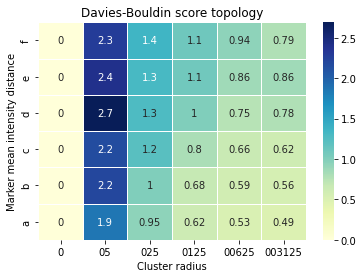

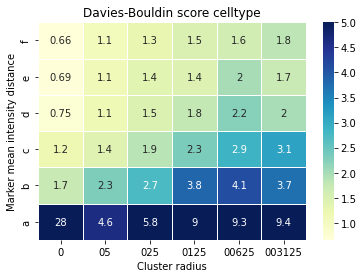

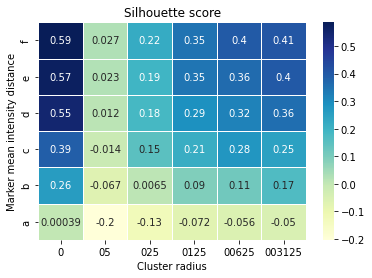

In [56]:
path = "/rtsess01/compute/juno/shah/users/pourmalm/final_grafiti_results/figures/"
dbs_top = daviesbouldin_df[['Condition','DBS_topology']]
dbs_ct = daviesbouldin_df[['Condition','DBS_celltype']]
ss = daviesbouldin_df[['Condition','Silhouette_score']]

dbs_top['DBS_topology'] = pd.to_numeric(dbs_top['DBS_topology'])
dbs_top = dbs_top.groupby('Condition').median().reset_index()
dbs_top[['Number', 'Letter']] = dbs_top['Condition'].str.extract('(\d+)([a-zA-Z]+)')
dbs_top['DBS_topology'] = pd.to_numeric(dbs_top['DBS_topology'],errors='coerce')
dbs_top = dbs_top.pivot(index='Letter', columns='Number', values='DBS_topology')
dbs_top = dbs_top[['0', '05', '025', '0125', '00625', '003125']]
dbs_top = dbs_top.reindex(['f','e','d','c','b','a'])
sns.heatmap(dbs_top, annot=True, cmap='YlGnBu', linewidth=.5)
plt.xlabel('Cluster radius')
plt.ylabel('Marker mean intensity distance')
plt.title('Davies-Bouldin score topology')
plt.savefig(path+"db_top.pdf")
plt.show()

dbs_ct['DBS_celltype'] = pd.to_numeric(dbs_ct['DBS_celltype'])
dbs_ct = dbs_ct.groupby('Condition').median().reset_index()
dbs_ct[['Number', 'Letter']] = dbs_ct['Condition'].str.extract('(\d+)([a-zA-Z]+)')
dbs_ct['DBS_celltype'] = pd.to_numeric(dbs_ct['DBS_celltype'],errors='coerce')
dbs_ct = dbs_ct.pivot(index='Letter', columns='Number', values='DBS_celltype')
dbs_ct = dbs_ct[['0', '05', '025', '0125', '00625', '003125']]
dbs_ct = dbs_ct.reindex(['f','e','d','c','b','a'])
sns.heatmap(dbs_ct, annot=True, cmap='YlGnBu', linewidth=.5, vmax=5)
plt.xlabel('Cluster radius')
plt.ylabel('Marker mean intensity distance')
plt.title('Davies-Bouldin score celltype')
plt.savefig(path+"db_ct.pdf")
plt.show()

ss['Silhouette_score'] = pd.to_numeric(ss['Silhouette_score'])
ss = ss.groupby('Condition').median().reset_index()
ss[['Number', 'Letter']] = ss['Condition'].str.extract('(\d+)([a-zA-Z]+)')
ss['Silhouette_score'] = pd.to_numeric(ss['Silhouette_score'],errors='coerce')
ss = ss.pivot(index='Letter', columns='Number', values='Silhouette_score')
ss = ss[['0', '05', '025', '0125', '00625', '003125']]
ss = ss.reindex(['f','e','d','c','b','a'])
sns.heatmap(ss, annot=True, cmap='YlGnBu', linewidth=.5)
plt.xlabel('Cluster radius')
plt.ylabel('Marker mean intensity distance')
plt.title('Silhouette score')
plt.savefig(path+"silhouette.pdf")
plt.show()

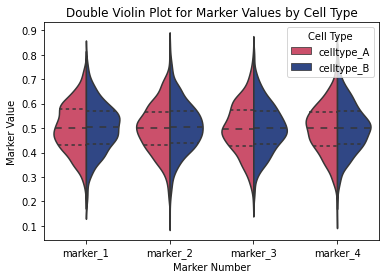

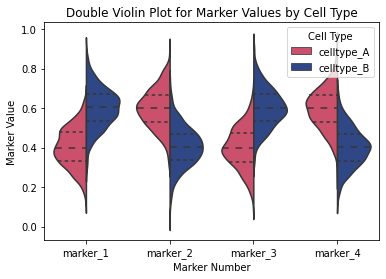

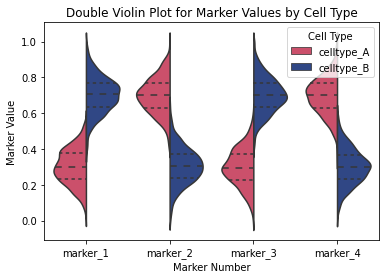

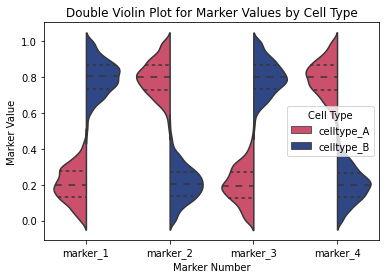

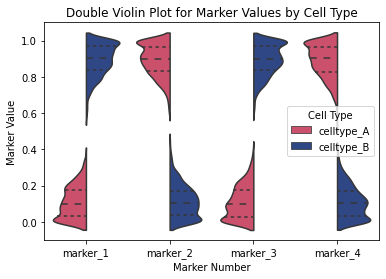

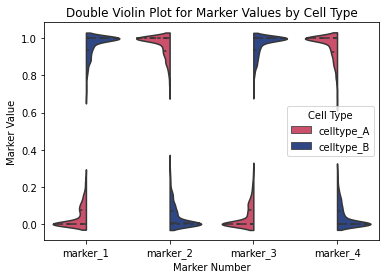

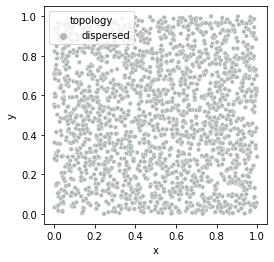

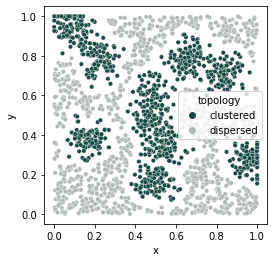

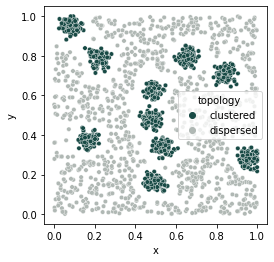

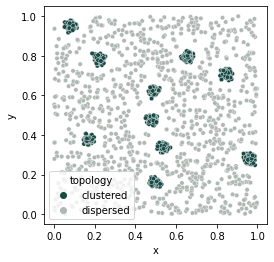

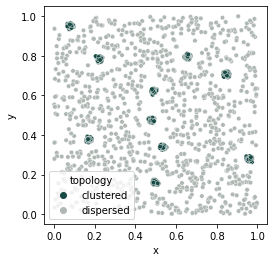

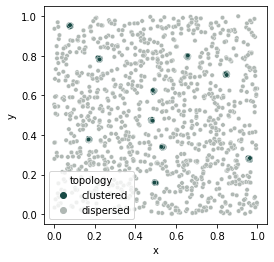

In [65]:
path = "/rtsess01/compute/juno/shah/users/pourmalm/final_grafiti_results/figures/"
a = [0.5,0.5,0.5,0.5]
b = [0.4,0.6,0.6,0.4]
c = [0.3,0.7,0.7,0.3]
d = [0.2,0.8,0.8,0.2]
e = [0.1,0.9,0.9,0.1]
f = [0,1,1,0]
params = [a,b,c,d,e,f]
def plot_violin(synthetic_dataset,filename):
    melted_data = pd.melt(synthetic_dataset, id_vars=['celltype'], value_vars=['marker_1', 'marker_2', 'marker_3', 'marker_4'])
    sns.violinplot(x='variable', y='value', hue='celltype', data=melted_data, split=True, inner='quart', palette={'celltype_A':'#df3c5f', 'celltype_B':'#224193'})
    plt.title('Double Violin Plot for Marker Values by Cell Type')
    plt.xlabel('Marker Number')
    plt.ylabel('Marker Value')
    plt.legend(title='Cell Type')
    plt.savefig(path+filename+".pdf")
    plt.show()
run = 5
#CONDITION 1: scenario 1
params_name = ['0a','0b','0c','0d','0e','0f']
for i, k in zip(params, params_name):
    val1,val2,val3,val4 = i
    synthetic_dataset = generate_synthetic_dataset_scenario1(num_cells=2000,
                                                            boundary_jitter=0,
                                                            num_markers=4,
                                                            marker_means_A=(val1,val2),
                                                            marker_means_B=(val3,val4),
                                                            marker_SDs_A=(0.1, 0.1),
                                                            marker_SDs_B=(0.1, 0.1),
                                                            seed=run)
    plot_violin(synthetic_dataset,k)
plt.figure(figsize=(4,4))
sns.scatterplot(x=synthetic_dataset['x'], y=synthetic_dataset['y'], hue=synthetic_dataset['topology'], s=20, palette={'clustered':'#184A45FF', 'dispersed':'#B0B8B4FF'})
plt.savefig(path+"dispersed.pdf")
plt.show()
#CONDITION 2: scenario 4 cluster radius 0.05
params_name = ['0.05a','0.05b','0.05c','0.05d','0.05e','0.05f']
for i, k in zip(params, params_name):
    val1,val2,val3,val4 = i
    synthetic_dataset = generate_synthetic_dataset_scenario4(num_cells=2000,
                                                cluster_probability=0.5,
                                                cluster_size=100,
                                                cluster_radius=0.05,
                                                marker_means_A=(val1,val2),
                                                marker_means_B=(val3,val4),
                                                marker_SDs_A=(0.1, 0.1),
                                                marker_SDs_B=(0.1, 0.1),
                                                dispersed_distance=0.05,
                                                num_markers=4,
                                                seed=run)
    plt.figure(figsize=(4,4))
    sns.scatterplot(x=synthetic_dataset['x'], y=synthetic_dataset['y'], hue=synthetic_dataset['topology'], s=20, palette={'clustered':'#184A45FF', 'dispersed':'#B0B8B4FF'})
    plt.savefig(path+"top0.05.pdf")
    plt.show()
    break
#CONDITION 3: scenario 4 cluster radius 0.025
params_name = ['0.025a','0.025b','0.025c','0.025d','0.025e','0.025f']
for i, k in zip(params, params_name):
    val1,val2,val3,val4 = i
    synthetic_dataset = generate_synthetic_dataset_scenario4(num_cells=2000,
                                                cluster_probability=0.5,
                                                cluster_size=100,
                                                cluster_radius=0.025,
                                                marker_means_A=(val1,val2),
                                                marker_means_B=(val3,val4),
                                                marker_SDs_A=(0.1, 0.1),
                                                marker_SDs_B=(0.1, 0.1),
                                                dispersed_distance=0.05,
                                                num_markers=4,
                                                seed=run)
    plt.figure(figsize=(4,4))
    sns.scatterplot(x=synthetic_dataset['x'], y=synthetic_dataset['y'], hue=synthetic_dataset['topology'], s=20, palette={'clustered':'#184A45FF', 'dispersed':'#B0B8B4FF'})
    plt.savefig(path+"top0.025.pdf")
    plt.show()
    break
#CONDITION 4: scenario 4 cluster radius 0.0125
params_name = ['0.0125a','0.0125b','0.0125c','0.0125d','0.0125e','0.0125f']
for i, k in zip(params, params_name):
    val1,val2,val3,val4 = i
    synthetic_dataset = generate_synthetic_dataset_scenario4(num_cells=2000,
                                                cluster_probability=0.5,
                                                cluster_size=100,
                                                cluster_radius=0.0125,
                                                marker_means_A=(val1,val2),
                                                marker_means_B=(val3,val4),
                                                marker_SDs_A=(0.1, 0.1),
                                                marker_SDs_B=(0.1, 0.1),
                                                dispersed_distance=0.05,
                                                num_markers=4,
                                                seed=run)
    plt.figure(figsize=(4,4))
    sns.scatterplot(x=synthetic_dataset['x'], y=synthetic_dataset['y'], hue=synthetic_dataset['topology'], s=20, palette={'clustered':'#184A45FF', 'dispersed':'#B0B8B4FF'})
    plt.savefig(path+"top0.0125.pdf")
    plt.show()
    break
#CONDITION 5: scenario 4 cluster radius 0.00625
params_name = ['0.00625a','0.00625b','0.00625c','0.00625d','0.00625e','0.00625f']
for i, k in zip(params, params_name):
    val1,val2,val3,val4 = i
    synthetic_dataset = generate_synthetic_dataset_scenario4(num_cells=2000,
                                                cluster_probability=0.5,
                                                cluster_size=100,
                                                cluster_radius=0.00625,
                                                marker_means_A=(val1,val2),
                                                marker_means_B=(val3,val4),
                                                marker_SDs_A=(0.1, 0.1),
                                                marker_SDs_B=(0.1, 0.1),
                                                dispersed_distance=0.05,
                                                num_markers=4,
                                                seed=run)
    plt.figure(figsize=(4,4))
    sns.scatterplot(x=synthetic_dataset['x'], y=synthetic_dataset['y'], hue=synthetic_dataset['topology'], s=20, palette={'clustered':'#184A45FF', 'dispersed':'#B0B8B4FF'})
    plt.savefig(path+"top0.00625.pdf")
    plt.show()
    break
#CONDITION 6: scenario 4 cluster radius 0.003125
params_name = ['0.003125a','0.003125b','0.003125c','0.003125d','0.003125e','0.003125f']
for i, k in zip(params, params_name):
    val1,val2,val3,val4 = i
    synthetic_dataset = generate_synthetic_dataset_scenario4(num_cells=2000,
                                                cluster_probability=0.5,
                                                cluster_size=100,
                                                cluster_radius=0.003125,
                                                marker_means_A=(val1,val2),
                                                marker_means_B=(val3,val4),
                                                marker_SDs_A=(0.1, 0.1),
                                                marker_SDs_B=(0.1, 0.1),
                                                dispersed_distance=0.05,
                                                num_markers=4,
                                                seed=run)
    plt.figure(figsize=(4,4))
    sns.scatterplot(x=synthetic_dataset['x'], y=synthetic_dataset['y'], hue=synthetic_dataset['topology'], s=20, palette={'clustered':'#184A45FF', 'dispersed':'#B0B8B4FF'})
    plt.savefig(path+"top0.003125.pdf")
    plt.show()
    break